## DA - Project 3
* Oskar Szudzik 148245,
* Krystian Moras 148243

In [13]:
import numpy as np
import pandas as pd

data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data[criteria_nr] = data[criteria_nr].apply(lambda x: target_map[x])

data_input = data.iloc[:, :criteria_nr]
data_target = data[criteria_nr]

data_input, data_target

(       0         1      2    3    4    5    6
 0    1.0  0.500000  0.000  1.0  1.0  1.0  0.0
 1    0.5  0.500000  0.000  0.0  0.0  1.0  0.0
 2    0.5  0.833333  0.000  0.0  0.5  0.0  0.0
 3    1.0  0.833333  0.000  1.0  1.0  1.0  1.0
 4    1.0  1.000000  0.125  1.0  0.5  0.0  0.0
 ..   ...       ...    ...  ...  ...  ...  ...
 270  1.0  1.000000  0.125  1.0  0.5  0.0  1.0
 272  0.5  0.500000  0.000  0.0  1.0  1.0  1.0
 273  0.5  1.000000  0.250  1.0  0.5  0.0  0.0
 274  1.0  0.833333  0.125  1.0  0.5  0.0  1.0
 275  1.0  1.000000  0.250  1.0  0.5  1.0  0.0
 
 [173 rows x 7 columns],
 0      1
 1      0
 2      1
 3      0
 4      1
       ..
 270    0
 272    0
 273    0
 274    0
 275    0
 Name: 7, Length: 173, dtype: int64)

### ML model - XGBoost

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target, test_size=0.2, random_state=667
)

In [16]:
params = {
    "max_depth": criteria_nr // 2,
    "eta": 0.1,
    "nthread": 2,
    "seed": 667,
    "eval_metric": "rmse",
    "monotone_constraints": "(" + ",".join(["1"] * criteria_nr) + ")",
    "n_estimators": 1,
}

model = xgb.XGBClassifier(**params)

_ =model.fit(X_train, y_train)

In [17]:
from helpers import *

Accuracy, F1, AUC

In [18]:
# TRAIN
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_train, predictions)
print("Accuracy train: %.4f%%" % (accuracy * 100.0))

fpr, tpr, thresholds = roc_curve(y_train, predictions, pos_label=1)
auc_tr = auc(fpr, tpr)
print("AUC train: %.4f%%" % (auc_tr * 100))

f1_train = f1_score(y_train, predictions, average='binary', pos_label=1)
print("F1 train: %.4f%%" % (f1_train * 100))

# TEST
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy test: %.4f%%" % (accuracy * 100.0))

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
auc_te = auc(fpr, tpr)
print("AUC test: %.4f%%" % (auc_te * 100))

f1_test = f1_score(y_test, predictions, average='binary', pos_label=1)
print("F1 test: %.4f%%" % (f1_test * 100))

Accuracy train: 68.8406%
AUC train: 63.8228%
F1 train: 50.5747%
Accuracy test: 68.5714%
AUC test: 63.0952%
F1 test: 47.6190%


<AxesSubplot: >

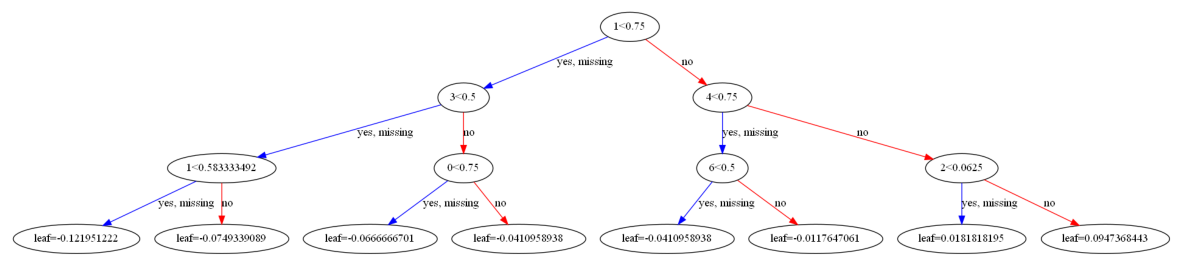

In [19]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(model, ax=ax, num_trees=0)

In [20]:
def partial_dependency(booster, X, y, crite = -1):
    grid = np.linspace(0,1,50)
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X.copy()
        X_temp[:, f_id] = val
        data = xgb.DMatrix( pd.DataFrame(X_temp) )
        y_pred[i] = np.average(booster.predict(data))

    return grid, y_pred

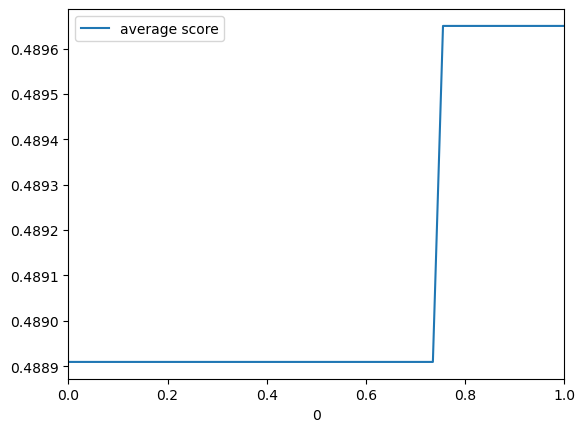

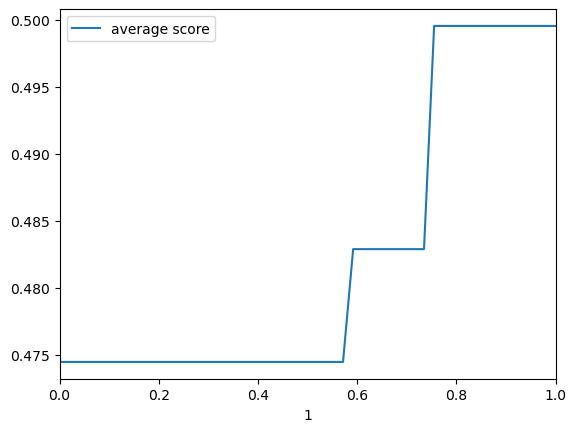

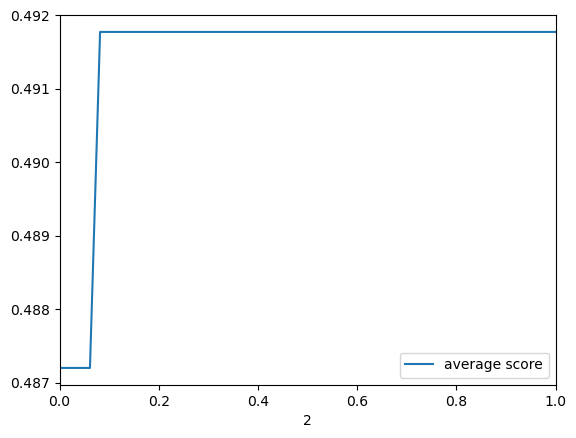

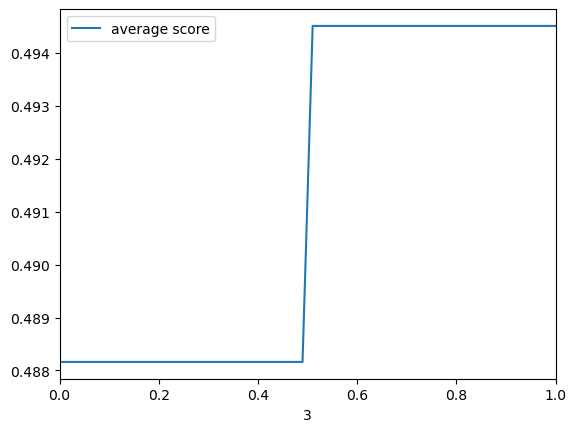

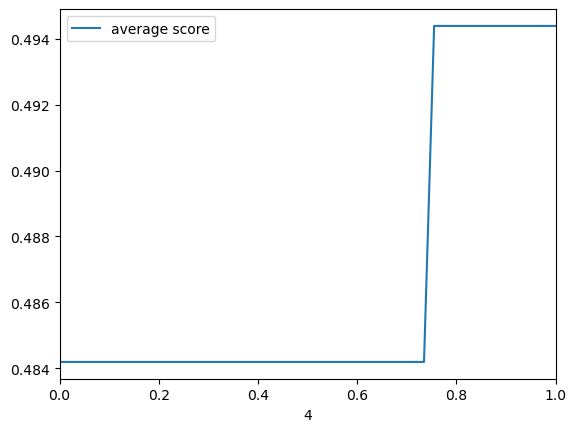

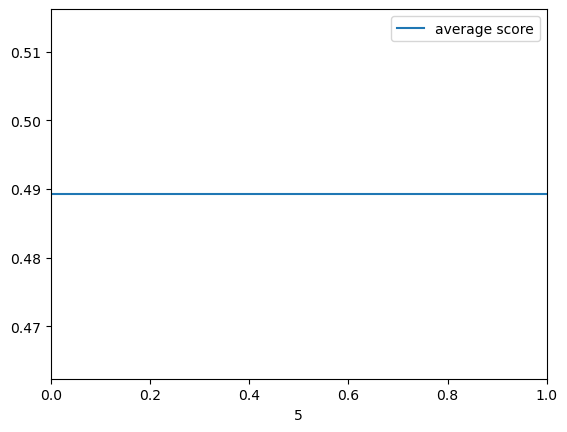

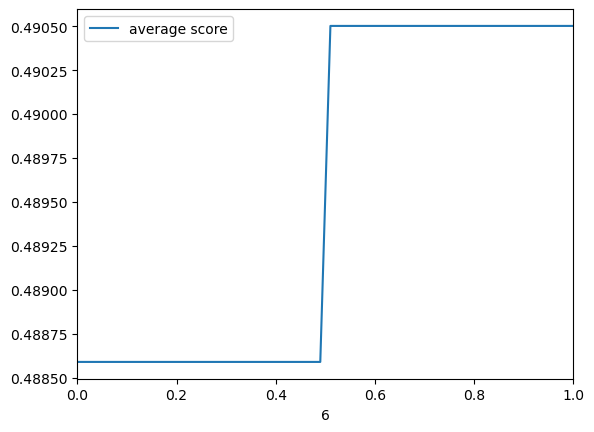

In [21]:
booster = model.get_booster()
grid = np.linspace(0,1,50)
for c in range(criteria_nr):
    y_pred = np.zeros(len(grid))
    for i, val in enumerate(grid):
        X_temp = X_train.values.copy()
        X_temp[:, c] = val
        data = xgb.DMatrix( pd.DataFrame(X_temp) )
        y_pred[i] = np.average(booster.predict(data))
        
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred,  label='average score')
    ax.set_xlim(0, 1)
    ax.set_xlabel(c)
    ax.legend()

In [22]:
booster.get_fscore()

{'0': 1.0, '1': 2.0, '2': 1.0, '3': 1.0, '4': 1.0, '6': 1.0}

We decided on the lower depth of the tree, since its metrics seem no-worse than deeper models.

Based on the model tree we can deduce that 5th criteria has very marginal effect on the decision. Also we see that 1st and 4th criteria are the most decisive.

Furthermore, looking at the partial dependency plots - we get the confirmation about our predictions. 1st and 4th plots picture the most interesting relations and 5th is linear.

### 3 alternatives experiment

In [29]:
print(X_test[:3])
print(y_test[:3], predictions[:3])

       0         1     2    3    4    5    6
69   1.0  0.833333  0.25  1.0  1.0  0.0  1.0
178  0.5  0.500000  0.00  0.0  0.0  0.0  0.0
115  1.0  0.833333  0.00  1.0  0.5  0.0  0.0
69     1
178    0
115    0
Name: 7, dtype: int64 [1, 0, 0]


Looking at the model tree we see that first 3 alternatives are classified correctly.
The minimal change to a single criterion to be classified to the other class:
* 1st record: 1st criterion -> 0.75 - 0.83 = -0.08
* 2nd record: 1st criterion -> 0.75 - 0.5 = +0.25; 4th criterion -> +0.75
* 3rd record: 4th criterion -> 0.75 - 0.5 = +0.25

And the final confirmation from SHAP values.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


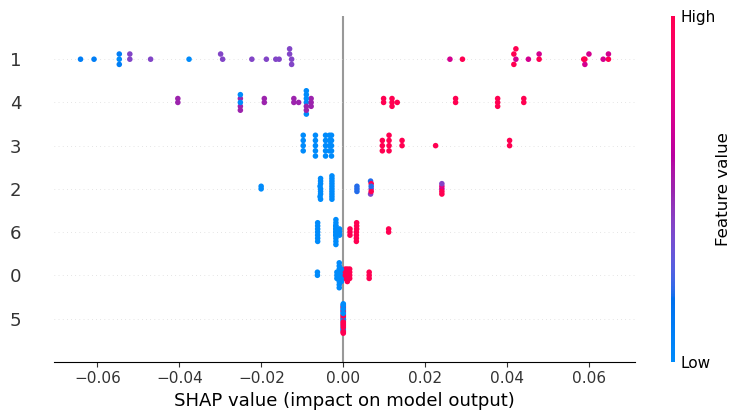

In [43]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Neural MCDA method - ANN-UTADIS

In [44]:
from nb_UTA import *

In [45]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data_target = data[criteria_nr].apply(lambda x: target_map[x])
data_input = data.iloc[:, :criteria_nr]
data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [46]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [47]:
PATH = "uta.pt2"
uta = Uta(criteria_nr, 30)
model = NormLayer(uta, criteria_nr)

acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.4f%%" % (acc * 100.0))
print("AUC train: \t%.4f%%" % (auc * 100.0))
print("F1 train: \t%.4f%%" % (f1 * 100))

print()

print("Accuracy test:\t%.4f%%" % (acc_test * 100.0))
print("AUC test: \t%.4f%%" % (auc_test * 100.0))
print("F1 test: %.4f%%" % (f1_test * 100))

100%|██████████| 200/200 [00:01<00:00, 121.23it/s]

Accuracy train:	68.1159%
AUC train: 	72.0569%
F1 train: 	0.0000%

Accuracy test:	57.1429%
AUC test: 	64.7959%
F1 test: 0.0000%


In [48]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [49]:
def getSimpleInput(val):
    return torch.FloatTensor([[val] * criteria_nr]).view(1, 1, -1).cpu()


hook = Hook(model.method.criterionLayerCombine, append_output)
xs = []
with torch.no_grad():
    for i in range(69):
        val = i / 68.0
        x = getSimpleInput(val)
        xs.append(val)
        uta(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = outs * model.method.sum_layer.weight.detach().numpy()[0]
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

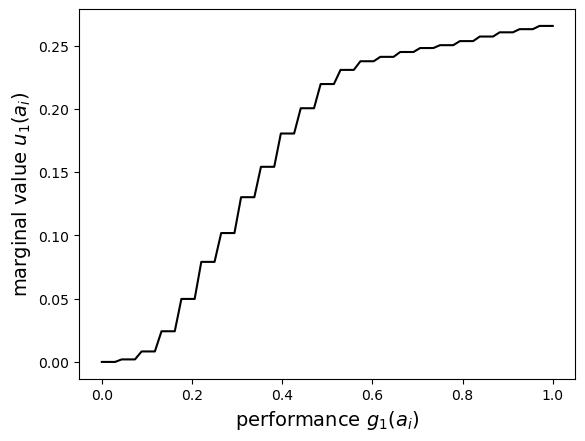

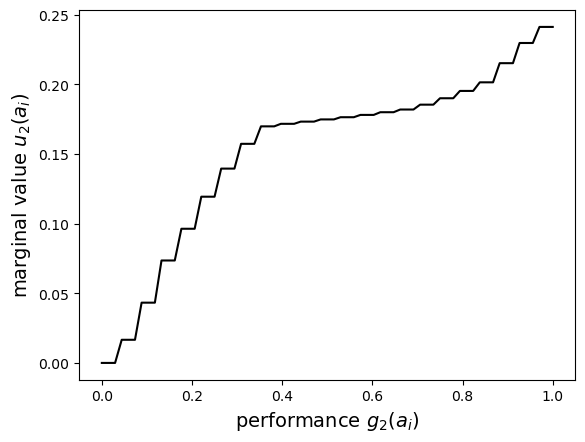

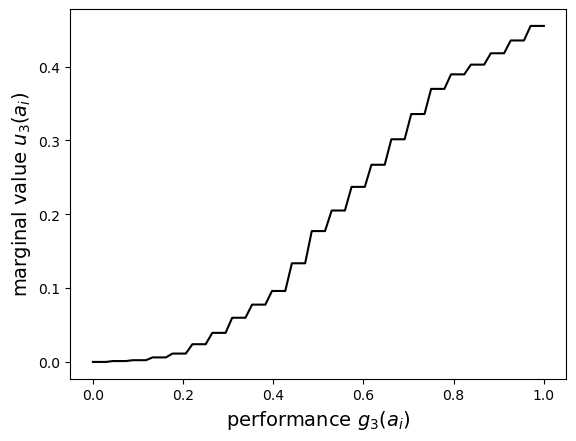

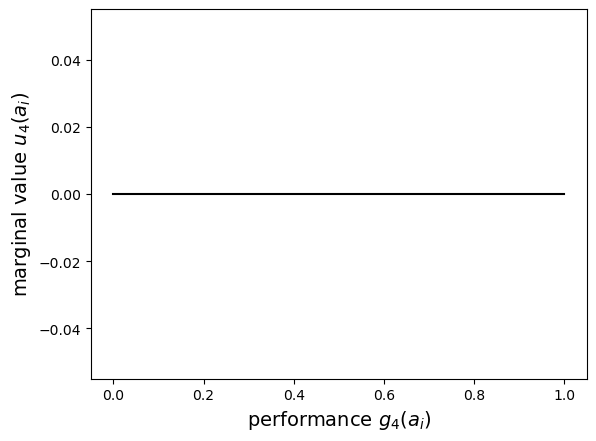

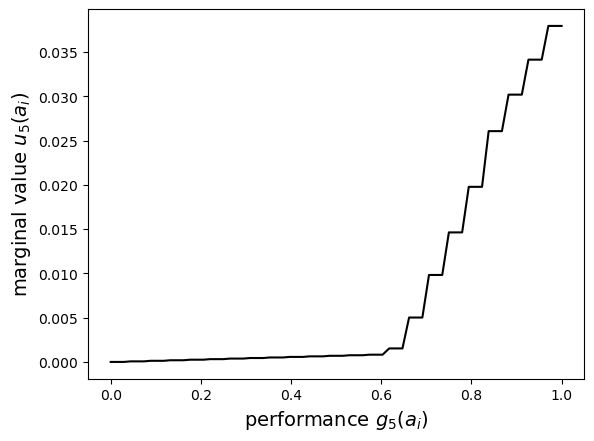

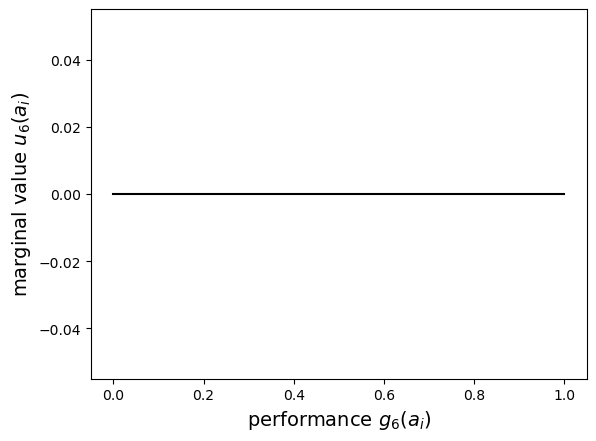

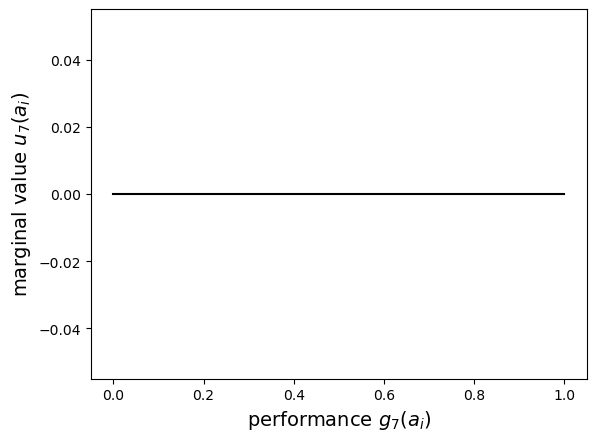

In [50]:
for i in range(criteria_nr):
    y = outs[:, i]
    plt.plot(xs, y.repeat(3), color="black")
    plt.ylabel("marginal value $u_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.xlabel("performance $g_{0}(a_i)$".format(i + 1), fontsize=14)
    plt.show()

In [51]:
stop

NameError: name 'stop' is not defined

### Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
data = pd.read_csv('monodata/breast cancer.csv', header=None)
data = data.drop_duplicates()

criteria_nr = 7
target_map = {1: 0, 2: 1}
data_target = data[criteria_nr].apply(lambda x: target_map[x])
data_input = data.iloc[:, :criteria_nr]
data_input = data_input.values.reshape(-1, 1, criteria_nr)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=667
)

In [ ]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [ ]:
PATH = "some_nn.pt2"
net = NeuralNetwork(criteria_nr, 30)

acc, acc_test, auc, auc_test = Train(net, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))

100%|██████████| 200/200 [00:01<00:00, 179.39it/s]

Accuracy train:	65.94%
AUC train: 	65.71%

Accuracy test:	69.42%
AUC test: 	71.43%
